<a href="https://colab.research.google.com/github/djzhendogg/Generative-Models-2025-ITMO/blob/main/Assignment%203/3_tricks_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 3

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

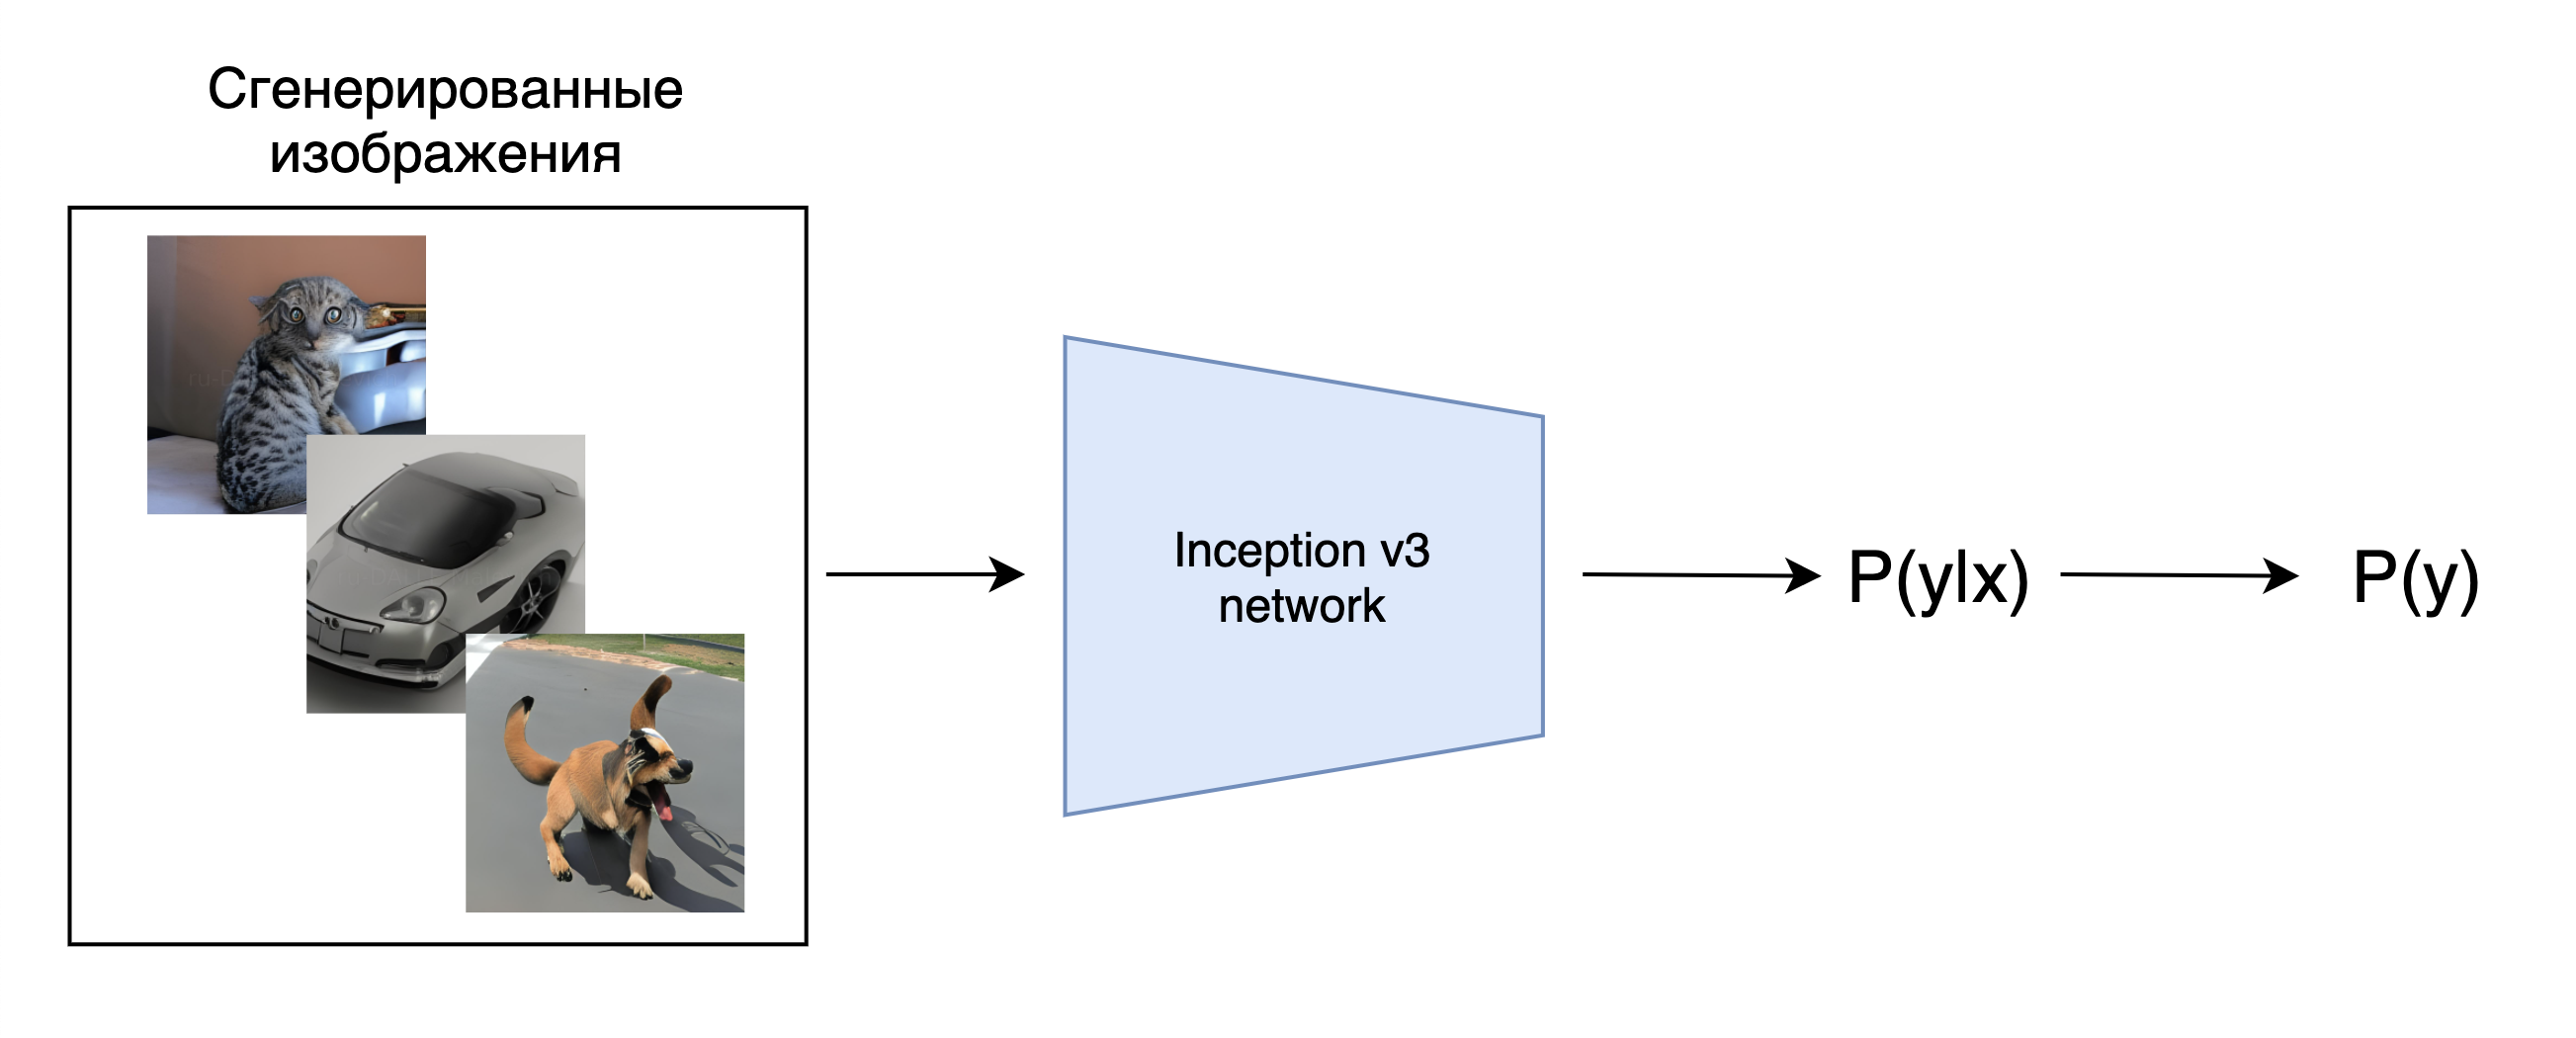

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

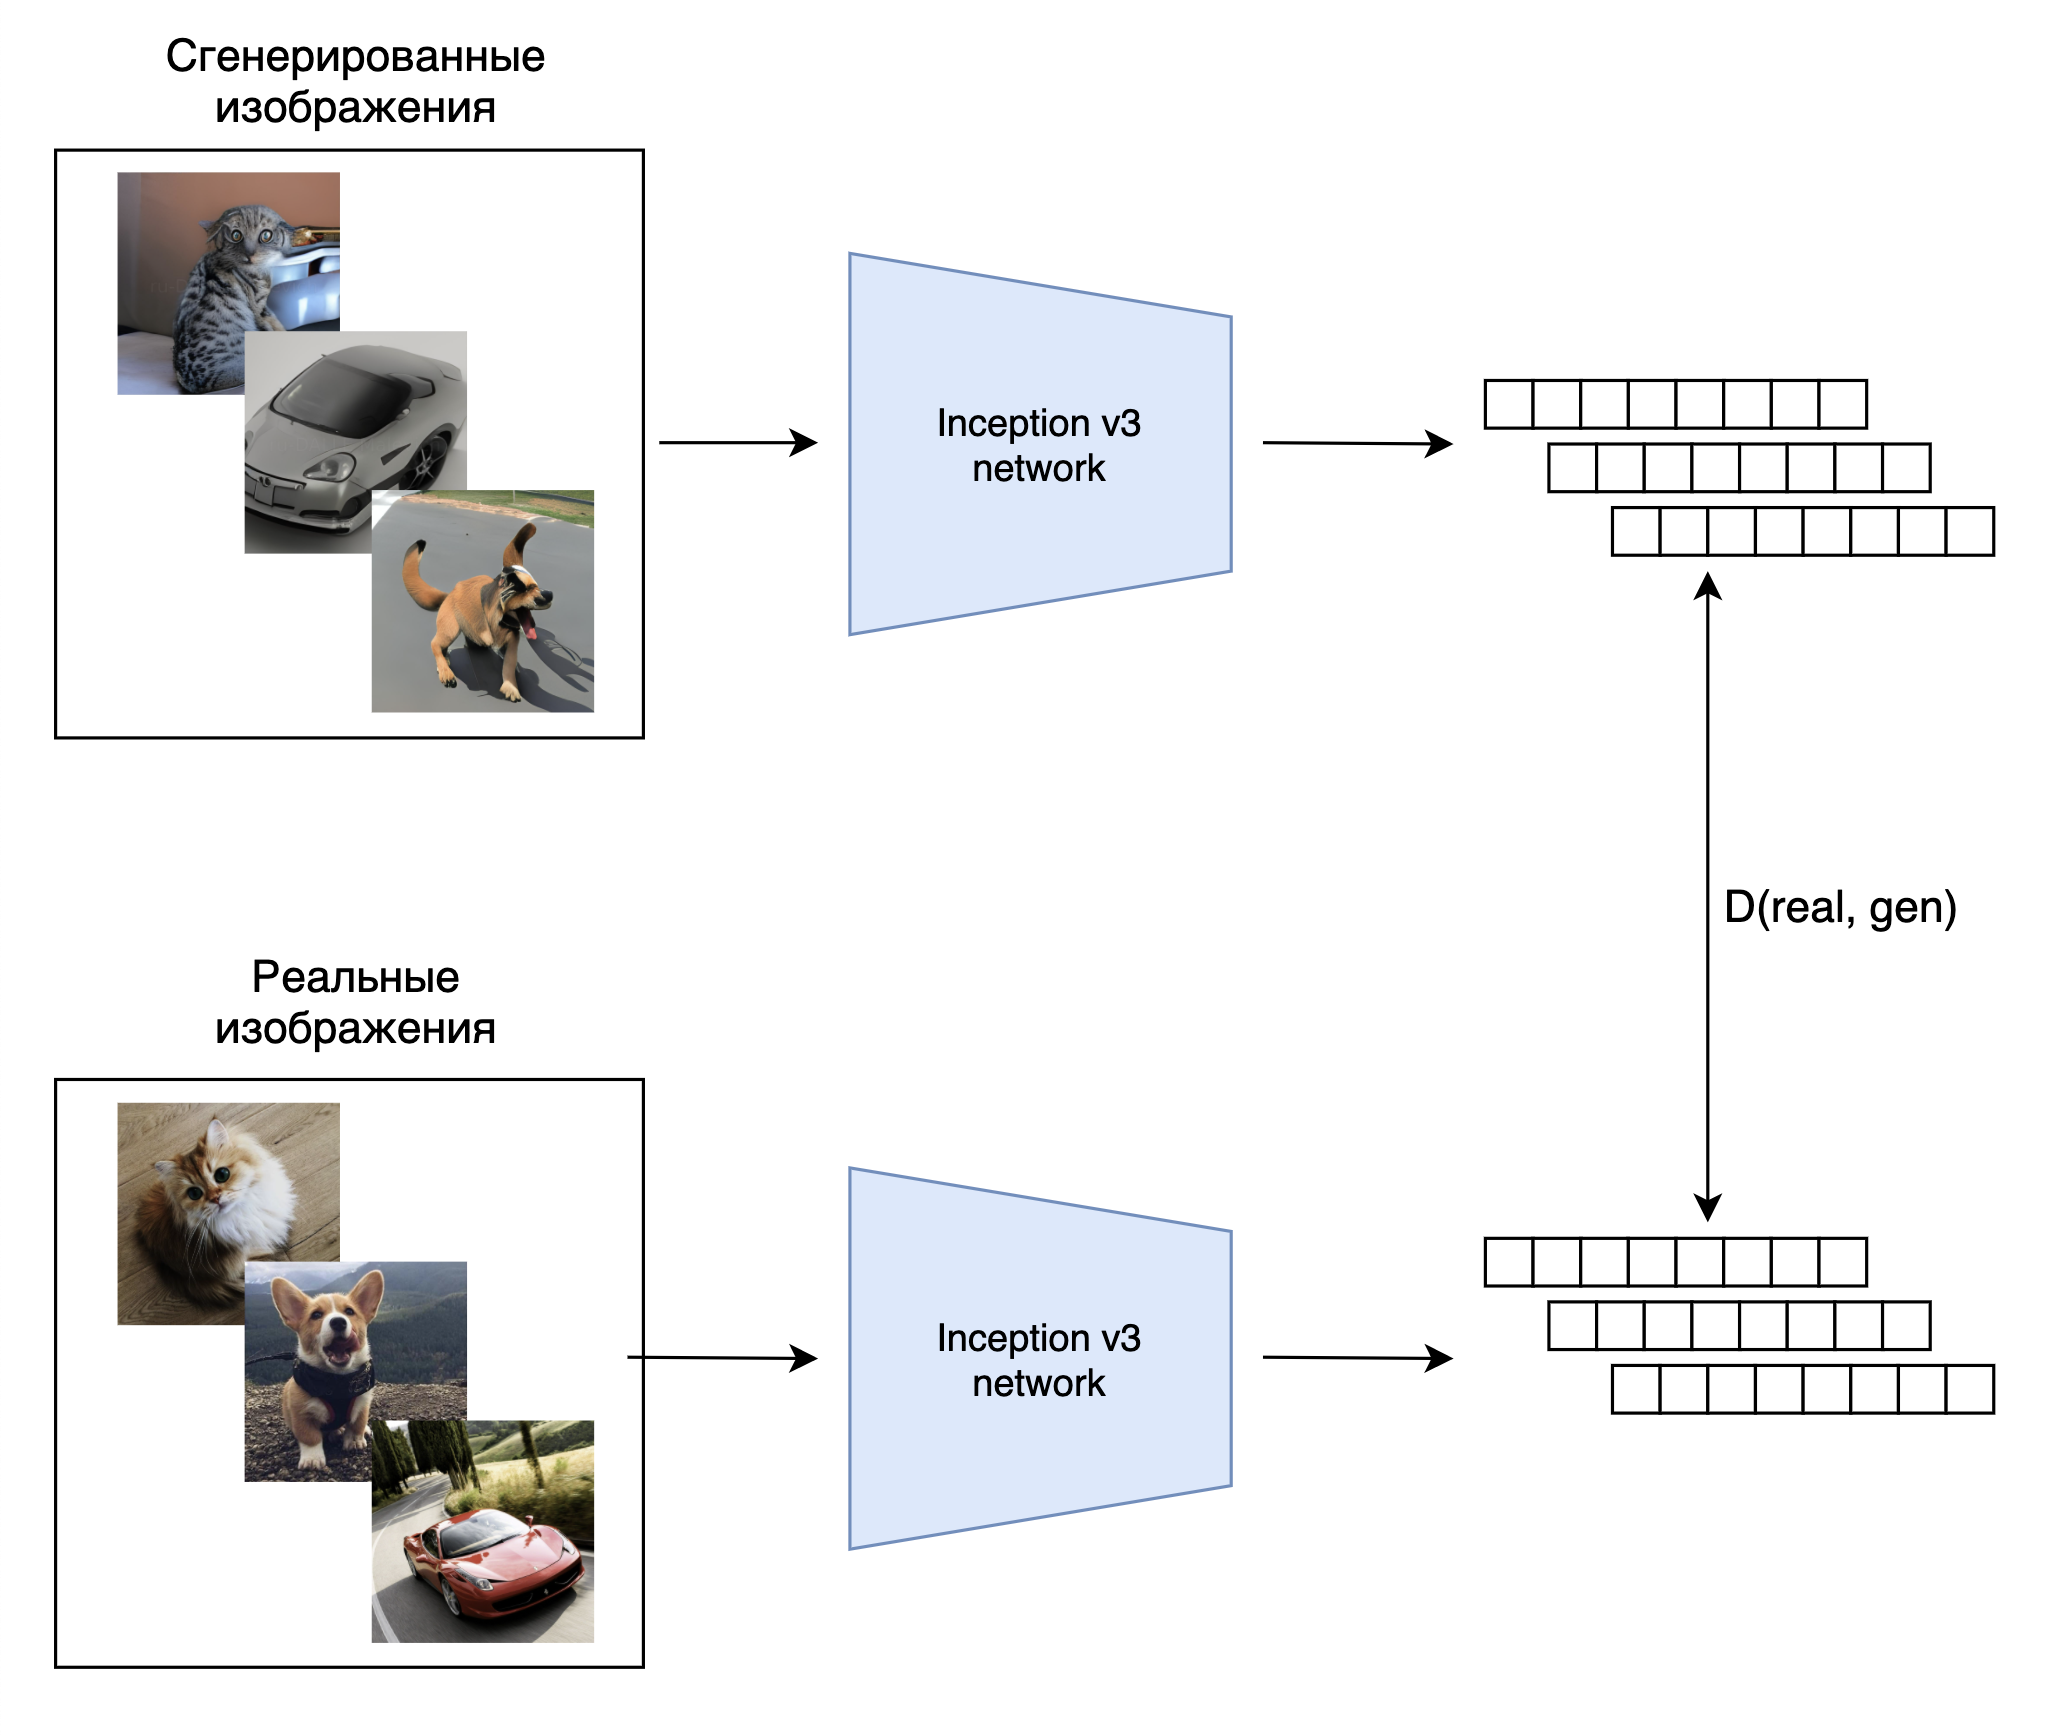

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN и диффузию (DDPM) на датасете CIFAR10. Для GAN вы можете использовать методы регуляризации, чтобы улучшить его качество, например label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных (вспомогательный код для трюков в ганах приведен в ноутбуке). Переиспользуйте код из 1 и 2 домашней работы.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей. Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
GAN | |
Diffusion | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s]


Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.86091506, -0.72967321, -0.59843135, -0.46718955,
        -0.33594775, -0.20470589, -0.07346404,  0.05777776,  0.18901956,
         0.32026136,  0.45150328,  0.58274508,  0.71398687,  0.84522879,
         0.97647059]),
 <BarContainer object of 15 artists>)

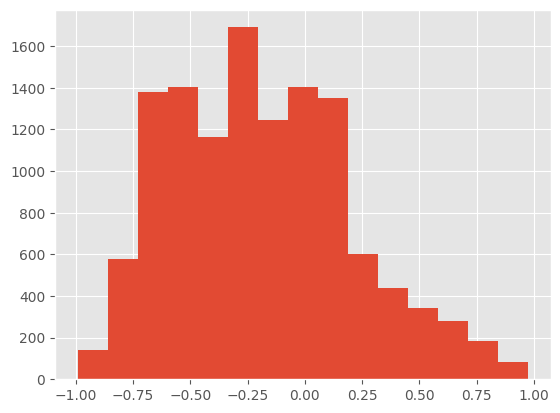

In [2]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

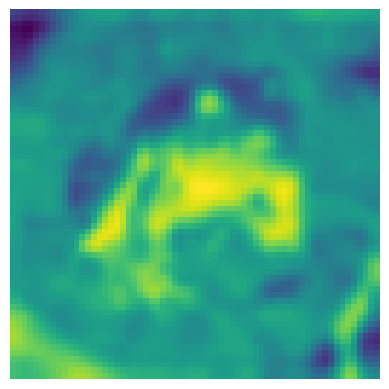

In [3]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    return img.add(1).div(2).clamp(0,1)

# show  image sample with matplotlib
plt.imshow(denorm(img)[0])
plt.axis('off')
plt.show()

In [4]:
from torch.utils.data import DataLoader

# define the dataloader
data_loader = DataLoader(cifar_dataset, CFG.batch_size, shuffle=True)

# Спектральная нормализация

In [5]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [6]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(

            SpectralNorm(nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.3),

            SpectralNorm(nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.3),

            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.3),

            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.3),

            SpectralNorm(nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(input.size(0), -1)


In [7]:
# create new Generator model

G = Generator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model

D = Discriminator(CFG.nc, CFG.ndf)

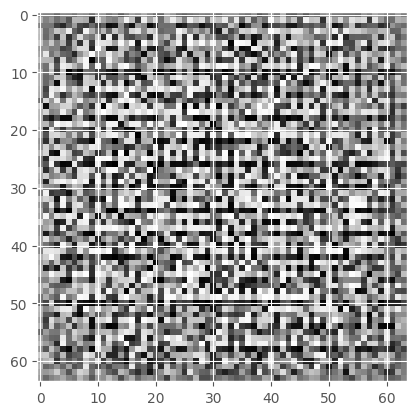

In [8]:
# show the output of model
y = G(torch.randn(2, CFG.nz, 1, 1))
plt.imshow(denorm(y)[0][0].to('cpu').detach(), cmap='gray')

In [ ]:
D(y)

tensor([[0.1150],
        [0.3425]], grad_fn=<ViewBackward0>)

In [ ]:
# feel free to reuse your training functions
criterion = nn.BCELoss()

g_optimizer = torch.optim.Adam(G.parameters(), lr=CFG.lr)
d_optimizer = torch.optim.Adam(D.parameters(), lr=CFG.lr)

In [ ]:
CFG.device

'cuda'

Discriminator Training

In [ ]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [ ]:

def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()


LABEL_SMOOTH = 0.95
def train_discriminator(images):
    real_smooth_max = 1.0
    real_smooth_min = 0.7
    fake_smooth_max = 0.3
    fake_smooth_min = 0.0
    FLIP_PROB = 0.05

    batch_size = images.size(0)

    real_labels_base = torch.rand(batch_size, 1).to(device) * (real_smooth_max - real_smooth_min) + real_smooth_min

    fake_labels_base = torch.rand(batch_size, 1).to(device) * (fake_smooth_max - fake_smooth_min) + fake_smooth_min

    flip_mask_real = (torch.rand(batch_size, 1).to(device) < FLIP_PROB)
    flipped_real_values = torch.rand(batch_size, 1).to(device) * (fake_smooth_max - fake_smooth_min) + fake_smooth_min
    real_labels = torch.where(flip_mask_real, flipped_real_values, real_labels_base)

    flip_mask_fake = (torch.rand(batch_size, 1).to(device) < FLIP_PROB)
    flipped_fake_values = torch.rand(batch_size, 1).to(device) * (real_smooth_max - real_smooth_min) + real_smooth_min
    fake_labels = torch.where(flip_mask_fake, flipped_fake_values, fake_labels_base)

    images = images.view(images.size(0), CFG.nc, CFG.image_size, CFG.image_size).to(device)

    outputs = D(images)
    # Loss for real images
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images

    z = torch.randn(batch_size, CFG.nz, 1, 1).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [ ]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (batch_size, CFG.nz, 1, 1))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)

    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

## Start the training process

In [ ]:
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (CFG.batch_size, CFG.nz, 1, 1))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        batch_size = images.size(0)
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/391], d_loss: 0.9482, g_loss: 1.9252, D(x): 0.82, D(G(z)): 0.20


KeyboardInterrupt: 

In [ ]:
!git clone https://github.com/djzhendogg/Generative-Models-2025-ITMO.git

In [10]:
d_losses = np.load('/content/Generative-Models-2025-ITMO/Assignment3/zhenya/d_losses.npy')
g_losses = np.load('/content/Generative-Models-2025-ITMO/Assignment3/zhenya/g_losses.npy')
real_scores = np.load('/content/Generative-Models-2025-ITMO/Assignment3/zhenya/real_scores.npy')
fake_scores = np.load('/content/Generative-Models-2025-ITMO/Assignment3/zhenya/fake_scores.npy')

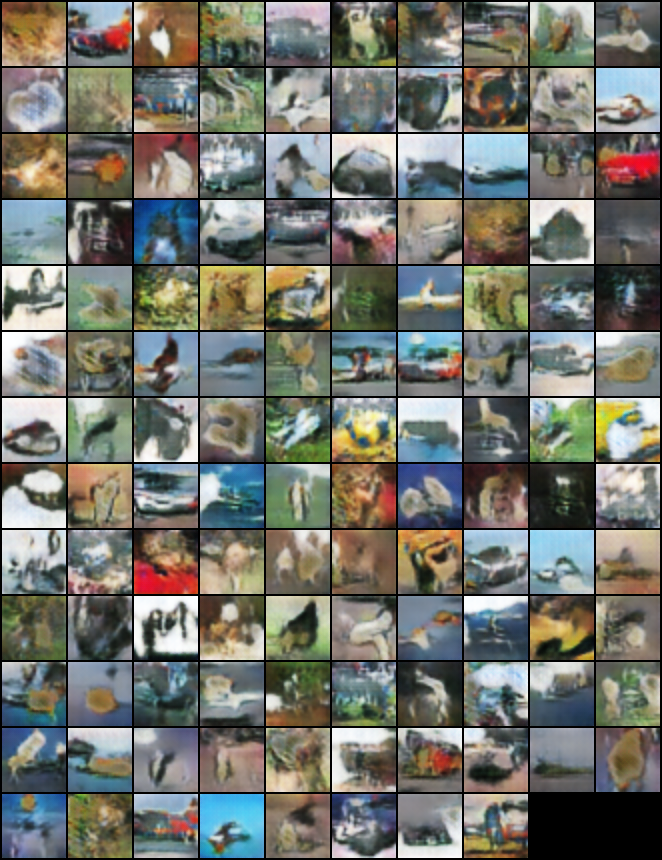

In [12]:
Image("/content/Generative-Models-2025-ITMO/Assignment3/zhenya/images/fake_images-0100.png")

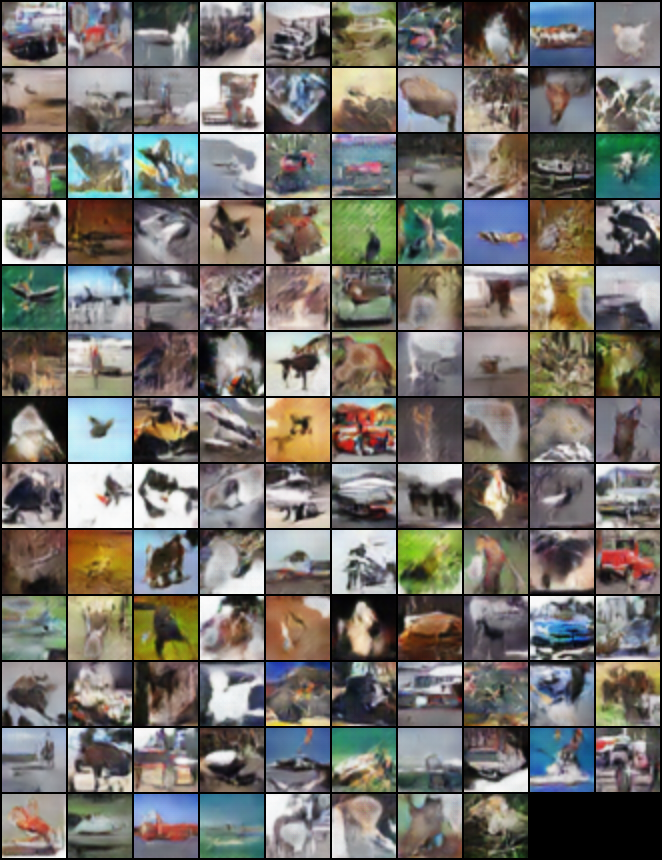

In [13]:
Image("/content/Generative-Models-2025-ITMO/Assignment3/zhenya/images/fake_images-0300.png")

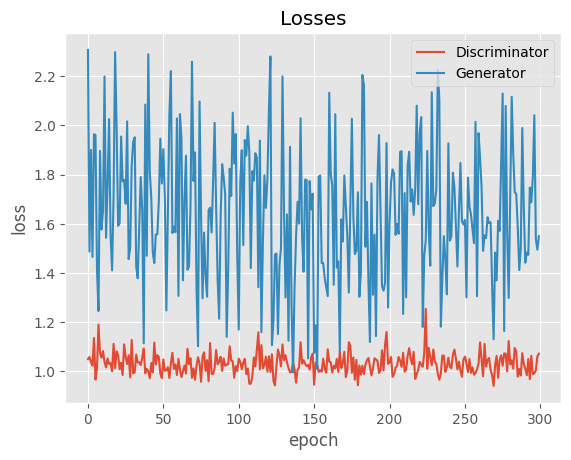

In [14]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

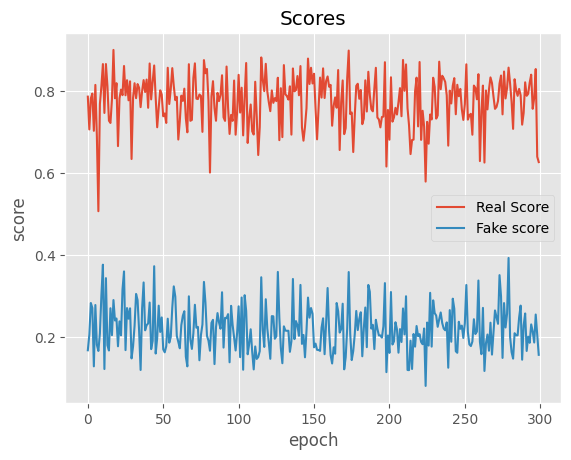

In [15]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [9]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git

!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 342 (delta 55), reused 96 (delta 46), pack-reused 230 (from 1)
Receiving objects: 100% (342/342), 93.34 KiB | 1.33 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Cloning into 'Generative-Models-2025-ITMO'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 254 (delta 23), reused 31 (delta 12), pack-reused 211 (from 1)
Receiving objects: 100% (254/254), 21.15 MiB | 18.89 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [ ]:
%cd pytorch-gan-metrics
#### Prepare Statistics for FID


/content/pytorch-gan-metrics


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
from arh import *

In [22]:
npz_path = "/content/drive/MyDrive/study/gen_model/fid_stats_cifar10_train.npz"
generatore_path = "/content/Generative-Models-2025-ITMO/Assignment3/zhenya/generator.pkl"
G_loaded = torch.load(generatore_path, weights_only=False, map_location=torch.device('cpu'))
G_loaded.eval()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [26]:
z = torch.randn(1, CFG.nz, 1, 1).to("cpu")
y = G_loaded(z)[0]

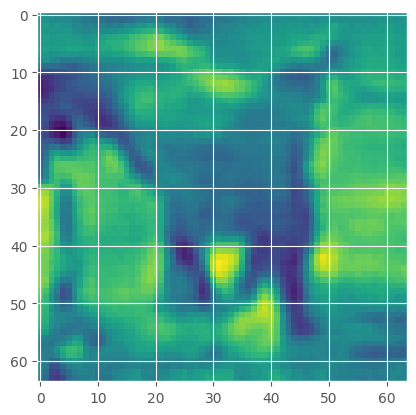

In [31]:
plt.imshow(y[0].detach().numpy())

In [34]:
 # import function from pytorch_gan_metrics
from pytorch_image_generation_metrics import (
    get_inception_score,
    get_fid,
    get_inception_score_and_fid
)
from pytorch_image_generation_metrics import ImageDataset
from torch.utils.data import DataLoader, Dataset
device = "cpu"
npz_path = "/content/drive/MyDrive/study/gen_model/fid_stats_cifar10_train.npz"
generatore_path = "/content/Generative-Models-2025-ITMO/Assignment3/zhenya/generator.pkl"
G_loaded = torch.load(generatore_path, weights_only=False, map_location=torch.device('cpu'))
G_loaded.eval()

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, noise_dim):
        self.G = G
        # self.noise_dim = noise_dim

    def __len__(self):
        return 500

    def __getitem__(self, index):
        z = torch.randn(1, CFG.nz, 1, 1).to(device)
        return self.G(z)[0]

# define dataset
dataset = GeneratorDataset(G_loaded, noise_dim=128)
#create dataloader
loader = DataLoader(dataset, batch_size=50, num_workers=0)
# Inception Score
# IS, IS_std = get_inception_score(loader)
# Frechet Inception Distance
# FID = get_fid(
#     loader, npz_path)
# Inception Score + Frechet Inception Distance
(IS, IS_std), FID = get_inception_score_and_fid(
    loader, npz_path)
print("IS: %.3f, IS_std: %.3f, FID: %.3f" % (IS, IS_std, FID))

AssertionError: Torch not compiled with CUDA enabled